# 1. Introduction

# Heart Disease Risk Assessment using Bayesian Networks

### Authors: Matteo Fasulo, Luca Tedeschini, Antonio Gravina, Luca babboni

### Course: Fundamentals of Artificial Intelligence and Knowledge Representation (Mod. 3) - Alma Mater Studiorum Università di Bologna

### Overview

**Cardiovascular diseases** (CVDs) are the number one cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 32% of all deaths worldwide. Four out of 5 CVD deaths are due to heart attacks and strokes, and one third of these deaths occur prematurely in people under 70 years of age [[1]](#1). 

The main risk factors for **heart disease** are unhealthy diet, physical inactivity, tobacco use and harmful use of alcohol. The effects may include raised blood pressure, raised blood glucose, raised blood lipids, and overweight and obesity [[1]](#1). Since the 1930s, research has identified diverse **CVD risk factors** [[2]](#2). Notably, the World Health Organization categorizes factors as modifiable (influenced by lifestyle) and non-modifiable [[3]](#3). Interestingly, modifiable factors can be significantly impacted by individual choices and interventions. 

In this notebook, we will use a **Bayesian Network** to assess the **risk of heart disease** in a patient based on these risk factors. We will face the modelling of **causal relations** between the risk factors and the disease, and we will use the network to make **predictions** about the risk of heart disease in a patient. The aim is to learn a model which **given** the risk factors of a patient as input (**evidence**), can predict the probability of the patient having heart disease. The causal relations between the risk factors and the disease will be both learned from data and from **domain knowledge** found in the **literature** and in **medical guidelines**.

The work was inspired by a paper [[4]](#4) in which the authors used a Bayesian Network to assess the risk of heart disease in a patient. Their work guided us in the choice of the risk factors and in the structure of the network. However, we will use a different dataset and we will use a different approach to learn the parameters of the network.

# 2. Preprocessing

## 2.1 Importing the libraries

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import networkx as nx

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import *
from pgmpy.inference import VariableElimination
from pgmpy.metrics import *
from pgmpy.metrics.bn_inference import *
from pgmpy.readwrite import XMLBIFWriter

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *

## 2.2 Description of the dataset

The original dataset [[5]](#5) was retrieved from Kaggle. 5 heart disease datasets were combined on over 11 common features commonly know to be strictly related to the prediction of possible heart desease. 

The dataset contains the following attributes:

* Age: age of the patient [years]

* Sex: sex of the patient
    * M: Male
    * F: Female

* ChestPainType: chest pain type 
    * TA: Typical Angina
    * ATA: Atypical Angina
    * NAP: Non-Anginal Pain
    * ASY: Asymptomatic
    
* RestingBP: resting blood pressure [mm Hg]

* Cholesterol: serum cholesterol [mm/dl]

* FastingBS: fasting blood sugar 
    * 1: if FastingBS > 120 mg/dl
    * 0: otherwise

* RestingECG: resting electrocardiogram results 
    * Normal: Normal
    * ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    * LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria

* MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]

* ExerciseAngina: exercise-induced angina 
    * Y: Yes
    * N: No

* Oldpeak: oldpeak = ST [Numeric value measured in depression]

* ST_Slope: the slope of the peak exercise ST segment 
    * Up: upsloping
    * Flat: flat
    * Down: downsloping
    
* HeartDisease: target variable 
    * 1: heart disease
    * 0: Normal

## 2.3 Discretization

At first the dataset is loaded and all the continuous variables are discretized. The discretization is performed using the `cut` function of the `pandas` library. The discretization is performed in such a way to be as close as possible to the standard medical guidelines. For example, the `RestingBP` (indicating the resting blood pressure) is discretized in 3 categories: `90-120`, `120-140` and `140+` according to the following intervals: [90, 120], (120, 140], (140, +inf). The same is done for the other continuous variables like `Cholesterol` and `Oldpeak`.

In [33]:
def clean_data(data: pd.DataFrame):
    """
    Cleans the given DataFrame by performing various data transformations.

    Args:
        data (pd.DataFrame): The input DataFrame to be cleaned.

    Returns:
        pd.DataFrame: The cleaned DataFrame.

    """
    data = data[~(data['Cholesterol'] == 0) & ~(data['RestingBP'] == 0)]
    df = data.copy()
    df["Age"] = pd.cut(x=data["Age"], bins=[20, 40, 50, 60, 70, np.Inf], labels=[
        "20-40", "40-50", "50-60", "60-70", "70+"])

    df["RestingBP"] = pd.cut(x=data["RestingBP"], bins=[90, 120, 140, np.Inf], labels=[
        "90-120", "120-140", "140+"])

    df["Cholesterol"] = pd.cut(x=data["Cholesterol"], bins=[
        -np.Inf, 200, 240, np.Inf], labels=["<=200", "200-240", "240+"])

    df["MaxHR"] = pd.qcut(x=data["MaxHR"], q=4, labels=[
                          "low", "medium", "high", "very-high"])  # binning using quartiles

    df["Oldpeak"] = pd.cut(x=data["Oldpeak"], bins=[-np.Inf, 0.5, 1, 2, np.Inf], labels=[
        "<=0.5", "0-5-1", "1-2", "2+"])
    df['FastingBS'] = df['FastingBS'].map({0: 'N', 1: 'Y'})
    return df

<Axes: xlabel='Age'>

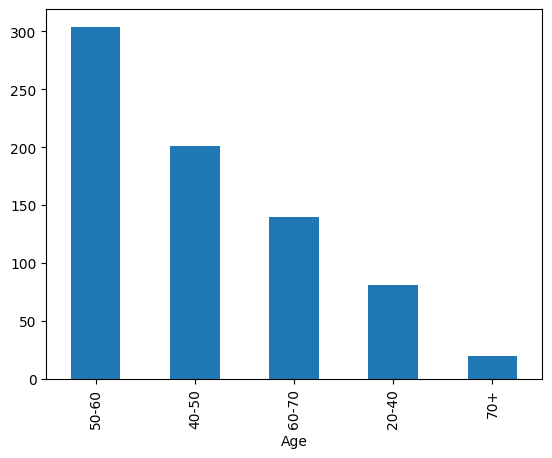

In [36]:
df['Age'].value_counts().plot(kind='bar')

In [69]:
data = pd.read_csv(f'data{os.sep}heart.csv')
df = clean_data(data)
df.to_csv(f'data{os.sep}heart_cleaned.csv')

print("The dataset contains %s observations and %s attributes" % df.shape)

df.head()

The dataset contains 746 observations and 12 attributes


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,20-40,M,ATA,120-140,240+,N,Normal,very-high,N,<=0.5,Up,0
1,40-50,F,NAP,140+,<=200,N,Normal,high,N,0-5-1,Flat,1
2,20-40,M,ATA,120-140,240+,N,ST,low,N,<=0.5,Up,0
3,40-50,F,ASY,120-140,200-240,N,Normal,low,Y,1-2,Flat,1
4,50-60,M,NAP,140+,<=200,N,Normal,low,N,<=0.5,Up,0


# 3. Data exploration

### Heart Disease Distribution in the Dataset

The dataset contains 746 samples and 11 features. The distribution of the target variable `HeartDisease` is shown in the following plot. The dataset is slightly imbalanced, with 390 samples of `HeartDisease` equal to 0 (Normal) and 356 samples of `HeartDisease` equal to 1 (affected with Heart Disease). ~~This is an important aspect to consider when training the model, as the model could be biased towards the majority class. We will take this into account when training the model.~~

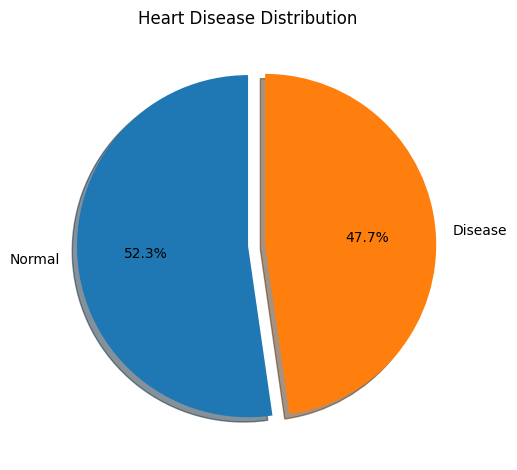

In [26]:
df["HeartDisease"].value_counts().plot(kind="pie", autopct='%1.1f%%', startangle=90, explode=[
    0, 0.1], shadow=True, labels=['Normal', 'Disease'], label='', title="Heart Disease Distribution")
plt.tight_layout()
plt.show()

### Train-Test Split

The dataset is split into a training set and a test set. The training set contains 85% of the samples, while the test set contains 15% of the samples. The split is performed using the `train_test_split` function of the `sklearn` library. The split is performed in such a way to maintain the same distribution of the target variable `HeartDisease` in the training and test set. This is done using the `stratify` parameter of the `train_test_split` function. The training set will be used to learn the parameters of the Bayesian Network, while the test set will be used to evaluate the performance of the model in terms of accuracy and other metrics.

In [27]:
target_variable = "HeartDisease"
X, y = df.drop(columns=target_variable), df[target_variable]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, shuffle=True, stratify=y)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# 4. Naïve Bayes Network

A [Naïve Bayesian classifier](https://www.ibm.com/topics/naive-bayes) is a specific type of classifier based on a Naïve Bayesian network. It is characterized by its semplicity, and it is built upond a simple assumption: all the features are conditional independent if the target feature is given.

They are widely used in Machine Learning thanks to their computational efficiency and their ease of implementation. They can also be expanded with other connections, and we will see that using an Hill Climbing algorithm in the next chapter.

Creating a Naïve Bayesian network in `pgmpy` is quite simple: once it is clear which are the features and which is the target variable, a simple list comprehension can build the network structure

In [28]:
network = [(target_variable, x) for x in df.columns[:-1]]
naive_bayesian = BayesianNetwork(network)

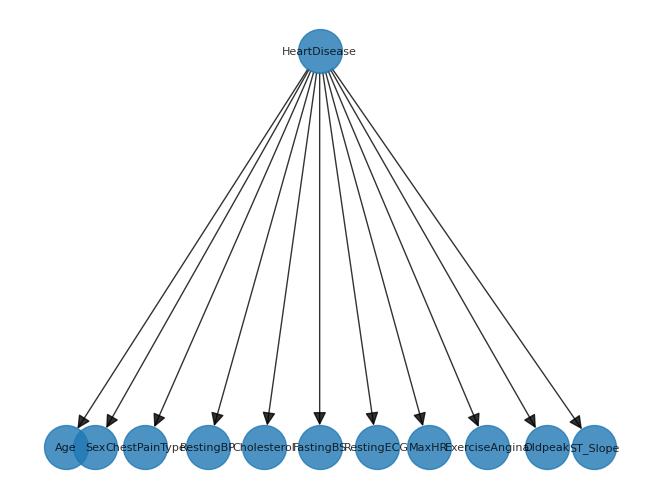

In [29]:
pos = nx.nx_agraph.graphviz_layout(naive_bayesian, prog="dot")
nx.draw(naive_bayesian, pos, with_labels=True, node_size=1000,
        font_size=8, arrowsize=20, alpha=0.8)

Once the structure of the network is built, the next step is to let it learn the parameters (_CPDs_) from the dataset. The choice fell [between two algorithms](https://towardsdatascience.com/maximum-likelihood-vs-bayesian-estimation-dd2eb4dfda8a):

* **Maximum Likelihood Estimation**: Given the likelihood function $\mathcal{L}(\theta | D) = f(D | \theta) = \prod{}_{i=1}^{N}f(x_i | \theta)$, the MLE algorithm tries to fit the parameter $\theta$ that maximize the likelihood function:
$$ \hat{\theta} = \argmax_\theta \prod_{i=1}^N f(x_i | \theta) = \frac{\partial}{\partial \theta} \prod_{i=1}^N f(x_i|\theta)$$ 
Since computing the derivatives of many products can get really complex, in the real world it is used the _log likelihood function_. This is done because the logs of productus is the sum of the logs, and that's simplify the computation, and also the $\argmax$ of a function doens't change if we are applying the log, since it is monotonic. So the real formula that is computed is
$$\text{log likelihood} : \int(\theta) = \ln \prod_{i=1}^Nf(x_i | \theta) = \sum_{i=1}^N \ln f(x_i | \theta)$$
Therefore,
$$ \hat{\theta} = \argmax_\theta \int (\theta)$$

This algorithm works the best if the dataset is big, since its outcome solely depends on the _observed_ data. It is also adviced when there is uncertainty about the prior.

* **Bayesian Estimation**: The equation used for Bayesian estimation is the following:
$$ \overbrace{\mathbb{P}(\theta | D)}^\text{posterior distribution} = \frac{\overbrace{\mathbb{P}(D|\theta)}^{\text{likelihood function}} \overbrace{\mathbb{P}(\theta)}^{\text{prior distribution}}}{\int \mathbb{P}(D|\theta) \mathbb{P}(\theta) d \theta}$$
the formula is quite similar to the *Bayes' theorem*, but instead of working with numerical value it uses models and pdfs. The Bayesian estimator tries to compute a distribution over the parameter space, called *posteriod pdf*, and denoted as $\mathbb{P}(\theta | D)$. This distribution represents how strongly we believe each parameter values is the one that generated our data, after taking into account both the observed data and the prior knowledge.

The bayesian estimations works the best if the priors of the networks *makes sense*.


Since we are working on a naïve network, the priors are probably not describing well how each feature affects each other, and we have proceeded using the **Maximum Likelihood Estimation**

To test the performance of the network, we have used `KFold` to compute an average of the `roc_auc` score given different **permutations** of the dataset, to get a more precise idea on the performances.

In [30]:
kfold = KFold(10, shuffle=True, random_state=42)

def bayesian_kfold(kfold, model):
    score = []
    for train, test in kfold.split(df):
        model.cpds = []
        model.fit(df.iloc[train, :], estimator=MaximumLikelihoodEstimator)
        y_pred = model.predict(df.iloc[test, :-1])
        score.append(roc_auc_score(df.iloc[test, -1], y_pred[target_variable]))
    return sum(score) / len(score)

In [31]:
%%capture
roc_auc_value = bayesian_kfold(kfold, naive_bayesian)

In [32]:
print(f"The roc_auc score for the naive bayesian network is {roc_auc_value:.2f}")

The roc_auc score for the naive bayesian network is 0.84


## Considerations
With the Naïve Bayesian classifier we get an overall good `roc_auc` score and we mantain a good computational performace. Is it possibile to improve the network? Does it make sense to add others **causal** link in between features?

# 5. Improving the Naïve Bayes network with Hill Climbing

The first approach to learn the structure of the Bayesian Network is to use an **Hill Climbing** algorithm.

The Hill Climbing algorithm is a greedy search algorithm which starts from an empty network (or an already built one) and adds or removes edges to maximize a score. The score is usually the **Bayesian Information Criterion (BIC)**, which is a trade-off between the likelihood of the data and the complexity of the model. Since it is a *local search algorithm*, it strongly depends on the starting network, and there is a very high risk of being stuck on a local Maximum. To avoid this, the algorithm is usually run multiple times with different initializations and the best network is selected.

The Hill Climbing algorithm is implemented in the `pgmpy` library. We have compared different scoring method to see which one works the best with our dataset.

In [37]:
%%capture

scores = {} # Dictionary to store the roc_auc_score for each scoring method
networks = {} # Dictionary to store the network structure for each scoring method

for scoring in ['k2score', 'bdeuscore', 'bdsscore', 'bicscore', 'aicscore']:
    network = HillClimbSearch(df, use_cache=False).estimate(scoring_method=scoring)
    networks[scoring] = network    
    model = BayesianNetwork(network)
    scores[scoring] = bayesian_kfold(kfold, model)

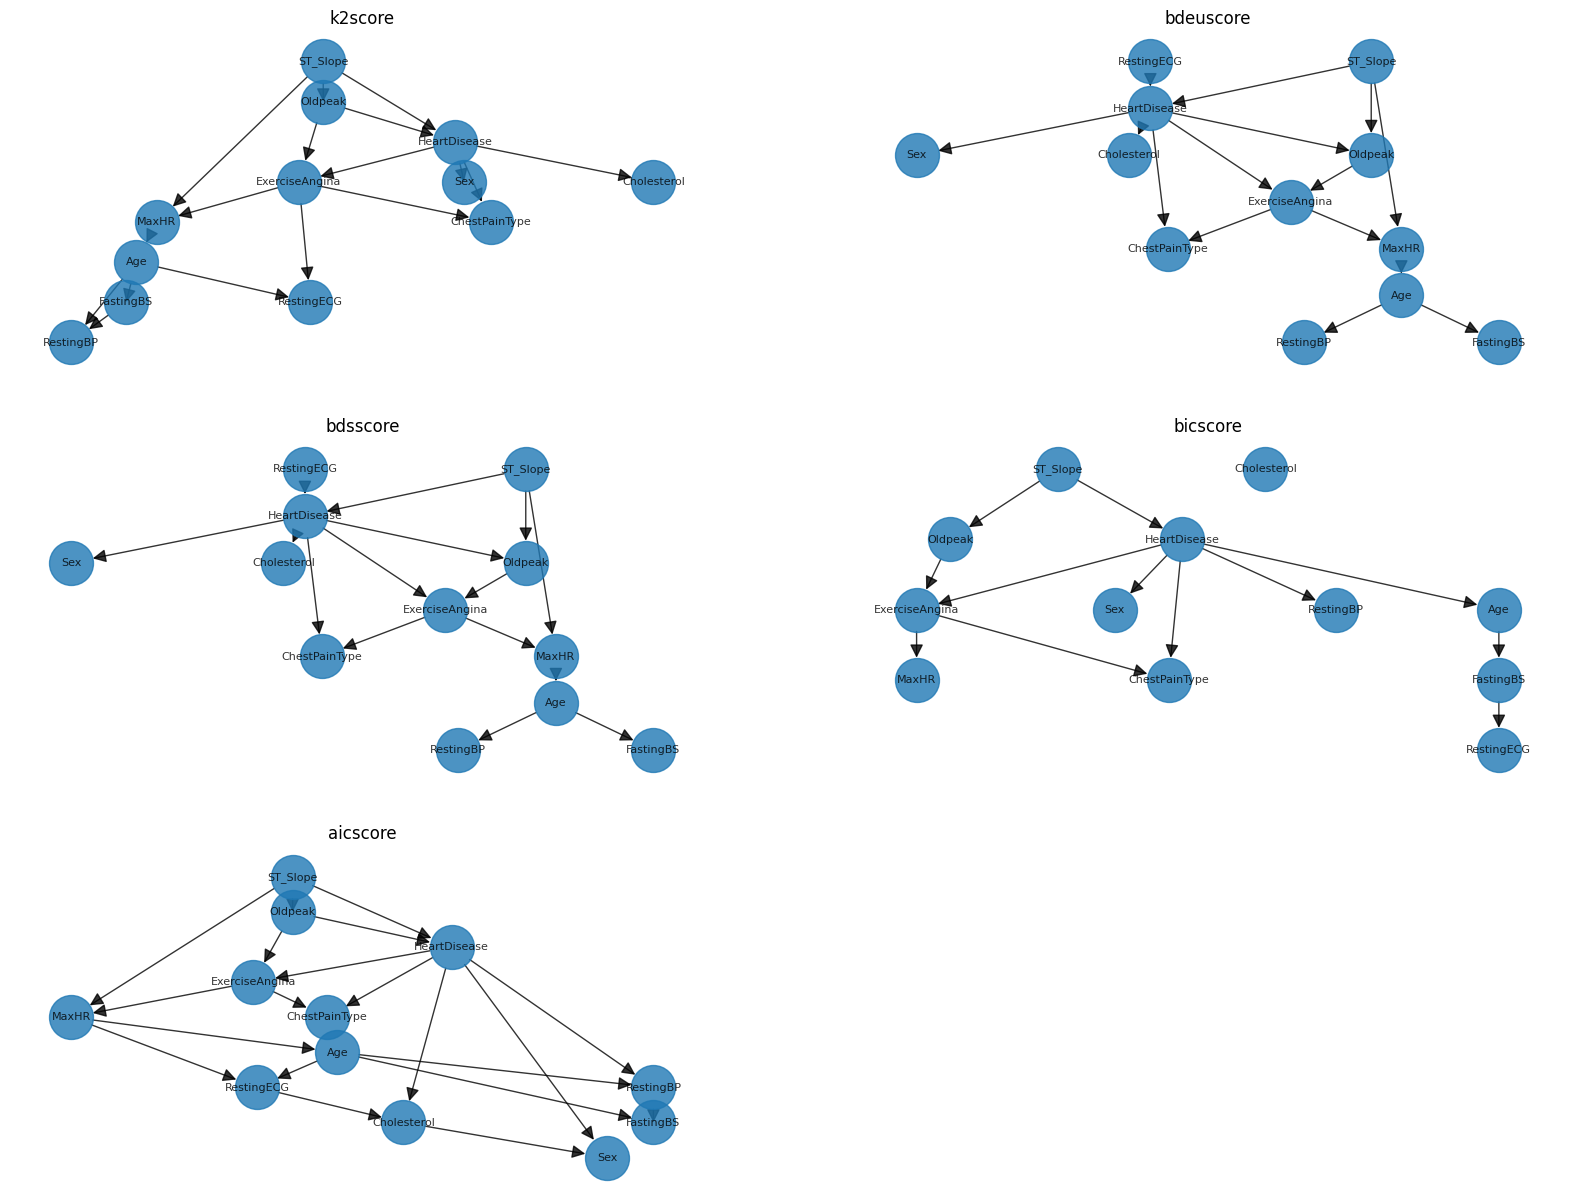

In [38]:
fig = plt.figure(figsize=(20,15))
i = 1
for scoring in networks:
    plt.subplot(3,2,i)
    pos = nx.nx_agraph.graphviz_layout(networks[scoring], prog="dot")
    nx.draw(networks[scoring], pos, with_labels=True, node_size=1000,
        font_size=8, arrowsize=20, alpha=0.8) 
    plt.title(scoring) 
    i += 1
plt.show()

In [39]:
pd.DataFrame(scores, index = ['ROC AUC'])

,k2score,bdeuscore,bdsscore,bicscore,aicscore
ROC AUC,0.868992,0.869626,0.869626,0.854584,0.855117


The performance are slighly higher w.r.t the Naïve Bayesian Classifier, but the network doesn't have any clear semantic. For example, the nodes 'Age' and 'Sex' should not have parent nodes, because they are not influenced by any other feature (but it make sense that they influence other features). This means that Hill Climbing learns a structure that may even have good performance, but it does not have (in most cases) semantical correctness.

From the comparison of the scoring parameter of the Hill Climbing below one can notice that they have an overall similar ROC AUC except for the `k2score`. However, the networks are different from each other and each network is not fully explainable. This means that:
- the choice of the scoring method does not influence so much the performance, even if the structures of the networks are different (`k2score` excluded)
- since the semantic is problematic, we need to add some constraint through blacklisting/whitelisting. This means that the Hill Climbing will not explore the connections written in the blacklist while they will use the connections reported in the whitelist.

Given these consideration we can choose as the scoring method for the Hill Climbing the `bdeuscore`, since it has the best performance, and build an unconstraied network which we can improve manually.

# 6. Running Hill Climbing Unconstrained

## 6.1 How the Bayesian Networks are represented

The libraries used in this notebook represents the bayesian network as a **Directed Acyclic Graph (DAG)**.

A DAG is a graph that has a topological ordering, which means that the edges are oriented: they have a starting node and a destination node. This is important because the edges in the Bayesian Network represent the causal relation between the variables: the edge goes from the cause to the effect

~~In order to represent the structure of the Bayesian Network, we will use a **Directed Acyclic Graph (DAG)**. A DAG is a graph that has a topological ordering, which means that the nodes are ordered in such a way that the edges go from the lower nodes to the higher nodes. This is important because the edges in the Bayesian Network represent the causal relations between the variables. The edges go from the cause to the effect. The structure of the Bayesian Network is learned from the data using the Hill Climbing algorithm. The `networkx` library is used to visualize the structure of the Bayesian Network by first extracting the edges from the learned structure and then plotting the graph. Here `graphviz` is used to plot the graph by first getting the position of the nodes and then plotting the edges.~~

## 6.2 First run of the algorithm

In [40]:
hc_unconst = HillClimbSearch(df, use_cache=False).estimate(scoring_method='bdeuscore')

  0%|          | 0/1000000 [00:00<?, ?it/s]

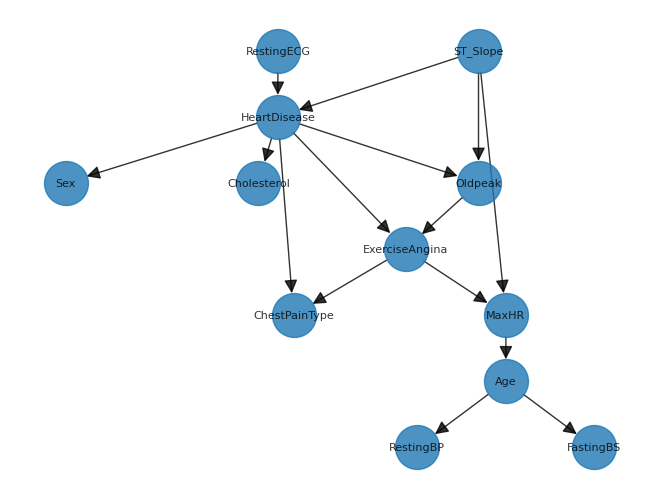

In [41]:
pos = nx.nx_agraph.graphviz_layout(hc_unconst, prog="dot")
nx.draw(hc_unconst, pos, with_labels=True, node_size=1000,
        font_size=8, arrowsize=20, alpha=0.8)

From the above plot, we can see that the structure of the Bayesian Network learnt from the data has some edges that are not meaningful. For example, the edges that points to `Age` and `Sex` are not meaningful. This is because the Hill Climbing algorithm is not aware of the domain knowledge and it tries to maximize the score by adding or removing edges. In the next section, we will use the domain knowledge to remove the edges that are not meaningful and to add the edges that are meaningful. 


## 6.3 Adding a blacklist

In this section we will add a blacklist to the Hill Climbing algorithm that will limit the creation of unexplainable networks. The black list is passed as a parameter to the Hill Climbing algorithm.

In [42]:
black_list = [(target_variable, 'Cholesterol'), 
              ('Oldpeak', target_variable),
              ('ST_Slope', target_variable),
              ('ST_Slope', 'MaxHR'),
              ('ExerciseAngina', 'Cholesterol'),
              ('ST_Slope', 'Oldpeak'),
              ('ExerciseAngina', 'RestingECG'),
              ('ExerciseAngina', 'ChestPainType')] + [(x, 'Sex')for x in df.columns] + [(x, 'Age') for x in df.columns]

In [43]:
%%capture
hc_const = HillClimbSearch(df, use_cache=False).estimate(
    scoring_method='BDeuScore', black_list=black_list)

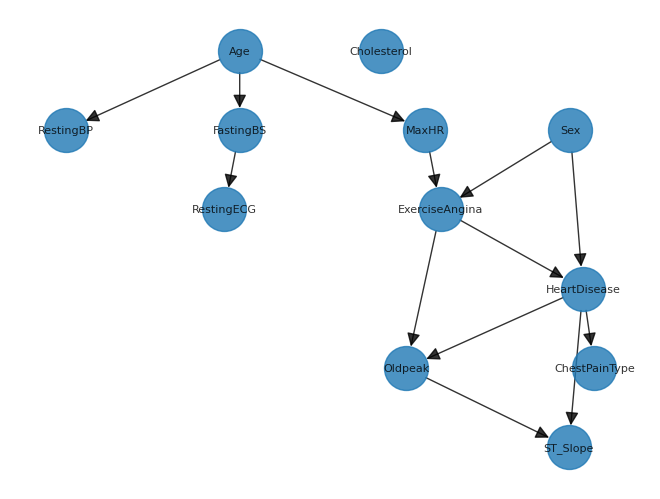

In [44]:
pos = nx.nx_agraph.graphviz_layout(hc_const, prog="dot")
nx.draw(hc_const, pos, with_labels=True,
        node_size=1000, font_size=8, arrowsize=20, alpha=0.8)

As we can see the new structure of the Bayesian Network still has some edges that are not meaningful. Note that `Cholesterol` now is a singleton node, meaning that it is not connected to any other node. This is because the Hill Climbing algorithm removed the edge between `Cholesterol` and `HeartDisease` and there are no other edges that connect `Cholesterol` to the other nodes.

This is semantically wrong because `Cholesterol` is a risk factor for heart disease and it should be connected to the `HeartDisease` node. We will use the references found in the literature and in the medical guidelines to adjust the edges.

## 6.4 Manually adding edges to the network

In [45]:
hc_const.add_edge('Sex', 'Cholesterol')
hc_const.add_edge('Cholesterol', target_variable)
hc_const.add_edge('Oldpeak', 'ST_Slope')
hc_const.add_edge('RestingECG', target_variable)
hc_const.add_edge('RestingBP', target_variable)
hc_const.add_edge('Cholesterol', 'RestingBP')
hc_const.add_edge('FastingBS', target_variable)
hc_const.add_edge('Age', 'Cholesterol')

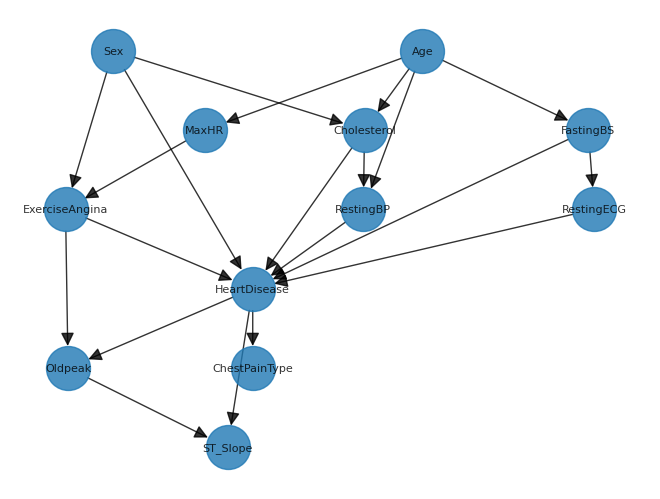

In [46]:
pos = nx.nx_agraph.graphviz_layout(hc_const, prog="dot")
nx.draw(hc_const, pos, with_labels=True,
        node_size=1000, font_size=8, arrowsize=20, alpha=0.8)

The structure now starts to have a more realistic semantic meaning but it is still not explainable in some nodes TODO: DIRE QUALI NODI NON HANNO SENSO. 

Inferring the structure of the network from the data is not enough to obtain a meaningful one, we need to use domain knowledge to add and remove edges to it to get a fully explainable network.

Just for comparison, here are the performance of this constrained network compared to the results. Firstly we need to convert the estimated DAG to a Bayesian Network and then we will learn the parameters of the network from the data using the `fit` method of the `BayesianModel` class using the `MaximumLikelihoodEstimator` as the estimator.

In [ ]:
hc_const_model = BayesianNetwork(hc_const.edges())

In [48]:
%%capture
hc_const_model.cpds = [] # Clear the cpds
hc_const_model.fit(train, estimator=MaximumLikelihoodEstimator)
hc_const_model.get_cpds()
assert hc_const_model.check_model()

~~After fitting the model the Conditional Probability Tables (CPTs) are learned from the data. The CPTs are the parameters of the Bayesian Network and they represent the probability of each node given its parents. The CPTs are learned using the `fit` method of the `BayesianModel` class. The `fit` method uses the `MaximumLikelihoodEstimator` class to learn the parameters of the network.~~

In [49]:
y_pred = hc_const_model.predict(X_test)
y_pred.head()

  0%|          | 0/109 [00:00<?, ?it/s]

,HeartDisease
0,0
1,1
2,0
3,0
4,0


In [51]:
accuracy_score(y_test, y_pred[target_variable])

0.8571428571428571

In [52]:
roc_auc_score(y_test, y_pred[target_variable])

0.856731691717301

# 7. Markov Blanket: creating a network fully aimed to maximize performances

In [54]:
from sklearn.preprocessing import OrdinalEncoder    

In [55]:
encoder = OrdinalEncoder().set_output(transform='pandas')

X_train_oenc, X_test_oenc, y_train_oenc, y_test_oenc = train_test_split(
    encoder.fit_transform(X), y, test_size=0.15, random_state=42, shuffle=True, stratify=y)

train_oenc = pd.concat([X_train_oenc, y_train_oenc], axis=1)
test_oenc = pd.concat([X_test_oenc, y_test_oenc], axis=1)

In [56]:
%%capture   

# Import the algorithm. PPIMBC is for classification and PPIMBR is for regression
from PyImpetus import PPIMBC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Initialize the PyImpetus object
model = PPIMBC(model=DecisionTreeClassifier(random_state=42, class_weight="balanced"), p_val_thresh=0.05, num_simul=100,
               simul_size=0.15, simul_type=1, sig_test_type="non-parametric", cv=5, random_state=42, n_jobs=-1, verbose=2)
# The fit_transform function is a wrapper for the fit and transform functions, individually.
# The fit function finds the MB for given data while transform function provides the pruned form of the dataset
model.fit_transform(X_train_oenc, y_train_oenc.values)
model.transform(X_test_oenc)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
/home/matteo/Documenti/VSCODE/BayesianClassifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/matteo/Documenti/VSCODE/BayesianClassifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/matteo/Documenti/VSCODE/BayesianClassifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_classificat

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


['ST_Slope', 'ChestPainType', 'ExerciseAngina', 'MaxHR', 'Age', 'Sex']
[40.77958478158941, 15.838789462685135, 12.774669543086691, 10.618188449319286, 8.692837209751566, 6.933704036732788]


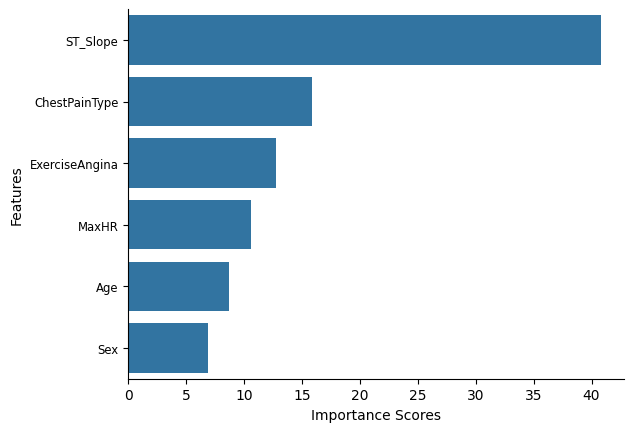

In [57]:
# Check out the MB
print(model.MB)
# Check out the feature importance scores for the selected feature subset
print(model.feat_imp_scores)
# Get a plot of the feature importance scores
model.feature_importance()

# 8. Domain expert advice

## 8.1 Motivational background

In this paragraph we will build a fully explainable network with the help of a Domain Expert, TODO AGGIUNGERE NOME E FACOLTà

We have decided to pursue this direction because:
* Using a structure learning algorithm on this relatively small dataset could lead to overfitting. We have seen that in the sixth paragraph.
* In general we think that the people that partecipate in this kind of survey are not a good representation of the whole population. In other worlds, we think that the dataframe could be **biased by definition**, and to let an algorithm learn on such biased dataset could lead to overfitting.
* Generally, a good roc_auc score is anything above 0.80. The network we are going to build can easily achieve that kind of precision, and even if it doesn't reach the score obtained before, it is fully explainable and more general, and we think that's the best possible outcome
* Bayesian network are based on the conditional independence assumption: if some edge doesn't represent an actual causal-consequence relation the whole structure could be weak

## 8.2 The network itself

In [58]:
domain_kg_model = BayesianNetwork([
    ('Age', 'Cholesterol'),
    ('Age', 'RestingECG'),
    ('Age', 'MaxHR'),
    ('Age', 'RestingBP'),
    ('Age', 'FastingBS'),
    ('Age', target_variable),
    ('Sex', 'Cholesterol'),
    ('Sex', 'MaxHR'),
    ('Sex', 'ExerciseAngina'),
    ('Sex', target_variable),
    ('RestingECG', target_variable),
    ('MaxHR', 'ExerciseAngina'),
    ('Cholesterol', target_variable),
    ('Cholesterol', 'RestingBP'),
    ('RestingBP', 'FastingBS'),
    ('FastingBS', target_variable),
    ('ExerciseAngina', target_variable),
    ('ExerciseAngina', 'Oldpeak'),
    ('ExerciseAngina', 'ST_Slope'),
    (target_variable, 'Oldpeak'),
    (target_variable, 'ST_Slope'),
    (target_variable, 'ChestPainType'),
    ('Oldpeak', 'ST_Slope'),
]
)

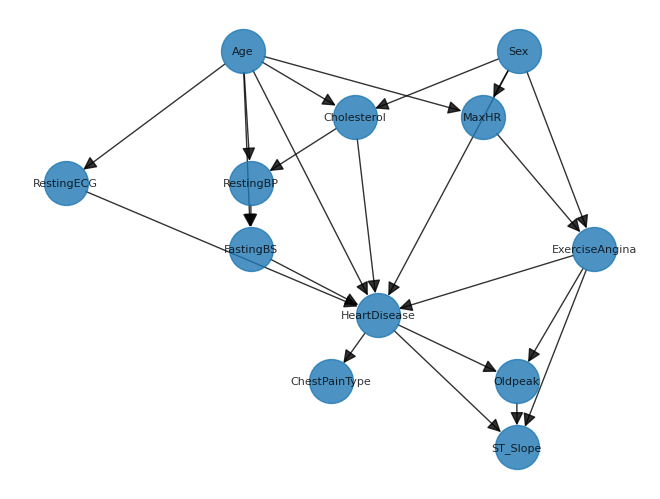

In [59]:
pos = nx.nx_agraph.graphviz_layout(domain_kg_model, prog="dot")
nx.draw(domain_kg_model, pos, with_labels=True,
        node_size=1000, font_size=8, arrowsize=20, alpha=0.8)

# 9. Bayesian network fully explainable

## 9.1 Changing the estimator

As stated in the paragraph 4, until now we have used the `MaximumLikelihooEstimator` to estimate the CPDs of our networks since our network were not explainable.

At this point we have changed direction and we are now more focussed on a semantically correct bayesian network. This means that the `BayesianEstimator` is a better choice, because it can learn actual correlation between datas.

In [60]:
%%capture
domain_kg_model.cpds = []
domain_kg_model.fit(train, estimator=BayesianEstimator, prior_type="BDeu")
domain_kg_model.get_cpds()
assert domain_kg_model.check_model()

In [61]:
y_pred = domain_kg_model.predict(X_test)

  0%|          | 0/109 [00:00<?, ?it/s]

In [62]:
fbeta_score(y_test, y_pred[target_variable], beta=2)

0.8679245283018868

In [63]:
accuracy_score(y_test, y_pred[target_variable])

0.875

In [64]:
roc_auc_score(y_test, y_pred[target_variable], )

0.8746402302526384

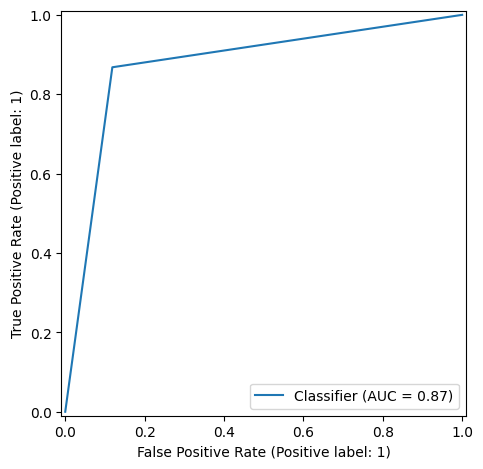

In [65]:
RocCurveDisplay.from_predictions(y_test, y_pred[target_variable])
plt.tight_layout()
plt.show()

In [66]:
if not os.path.isdir('model'):
    os.mkdir('model')
domain_kg_model.save(f'model{os.sep}heart_disease_model.bif')
writer = XMLBIFWriter(domain_kg_model)
writer.write_xmlbif(f'model{os.sep}heart_disease_model.xml')

# 10. Conclusion

# 11. References

<a id="1">[1]</a>
World Health Organization. (2024). Cardiovascular diseases (CVDs). <https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds)>

<a id="2">[2]</a>
Mahmood, S. S., Levy, D., Vasan, R. S., & Wang, T. J. (2014). The Framingham Heart Study and the epidemiology of cardiovascular disease: a historical perspective. Lancet (London, England), 383(9921), 999–1008. <https://doi.org/10.1016/S0140-6736(13)61752-3>

<a id="3">[3]</a>
WHO CVD Risk Chart Working Group (2019). World Health Organization cardiovascular disease risk charts: revised models to estimate risk in 21 global regions. The Lancet. Global health, 7(10), e1332–e1345. <https://doi.org/10.1016/S2214-109X(19)30318-3>

<a id="4">[4]</a>
Ordovas, J.; Rios-Insua, D.; Santos-Lozano, A.; Lucia, A.; Torres, A.; Kosgodagan, A.; and Camacho, J. (2023). A bayesian network model for predicting cardiovascular risk. Computer Methods and Programs in Biomedicine. <https://doi.org/10.1016/j.cmpb.2023.107405>

<a id="5">[5]</a>
fedesoriano. (September 2021). Heart Failure Prediction Dataset. Retrieved March 2024 from https://www.kaggle.com/fedesoriano/heart-failure-prediction.

<a id="6">[6]</a>
Heckerman, D., Geiger, D. & Chickering, D.M. Learning Bayesian Networks: The Combination of Knowledge and Statistical Data. Machine Learning 20, 197–243 (1995). https://doi.org/10.1023/A:1022623210503